<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_2D_Materials_Interfacial_Thermal_Conductance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [1]:
!pip install -q import_ipynb shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.5 MB/s eta 0:00:00


In [2]:
# utils
import os, sys, warnings, itertools
import shap
import random
import import_ipynb
import pandas as pd
import numpy as np
# colab
from google.colab import drive
# lightgbm
import lightgbm as lgb
# xgboost
import xgboost as xgb
# sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     KFold)
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              BaggingClassifier,
                              BaggingRegressor,
                              ExtraTreesClassifier,
                              ExtraTreesRegressor,
                              AdaBoostClassifier,
                              AdaBoostRegressor,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              StackingClassifier,
                              StackingRegressor,
                              VotingClassifier)
# vis
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Settings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [6]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Process Data

#### Load Data

In [8]:
data_dir = "Inputs/"

In [9]:
df = pd.read_excel(os.path.join(data_dir, 'TBC2D3D_dataset_variedKa_V5.xlsx'))
df.drop(['pairlabels_1', 'pairlabels_2'], axis=1, inplace=True)
df

,Ka,S_2D,h,m_2D,rho_2D,Natom,kappa_2D,TD_2D,BW_ZA,omega_0,m_3D,rho_3D,TD_3D,vac_3D,omega_3D,aflag,TBC
0,0.100000,5.223810,3.3500,24.022,2.279429,2,2000,638.085694,67.045635,1.473844,47.867002,4.587364,380,6.1,14.00,0,0.150407
1,0.332353,5.223810,3.3500,24.022,2.279429,2,2000,638.771098,65.832580,2.686899,47.867002,4.587364,380,6.1,14.00,0,1.588894
2,0.564706,5.223810,3.3500,24.022,2.279429,2,2000,640.255761,65.017104,3.502376,47.867002,4.587364,380,6.1,14.00,0,4.257096
3,0.797059,5.223810,3.3500,24.022,2.279429,2,2000,640.691240,64.358488,4.160991,47.867002,4.587364,380,6.1,14.00,0,7.757572
4,1.029412,5.223810,3.3500,24.022,2.279429,2,2000,641.585434,63.790732,4.728748,47.867002,4.587364,380,6.1,14.00,0,11.798419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,7.070588,10.957639,6.4251,439.040,10.355147,3,35,114.403371,6.074390,2.898891,3.326665,1.180000,254,2.8,2.68,1,158.248082
5456,7.302941,10.957639,6.4251,439.040,10.355147,3,35,115.254001,6.027143,2.946138,3.326665,1.180000,254,2.8,2.68,1,158.749150
5457,7.535294,10.957639,6.4251,439.040,10.355147,3,35,115.836044,5.980642,2.992639,3.326665,1.180000,254,2.8,2.68,1,159.133311
5458,7.767647,10.957639,6.4251,439.040,10.355147,3,35,114.270887,5.934853,3.038428,3.326665,1.180000,254,2.8,2.68,1,159.394347


#### Understand Data

In [10]:
reduce_memory_usage(df=df, category=False)

Memory usage of dataframe is 0.708282 MB!
Memory usage after optimization is 0.166748 MB!
Decreased by 76.5%


In [11]:
summarize_columns(df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,Ka,float16,0,0.0,35,0.099976,0.332275,0.564941
1,S_2D,float16,0,0.0,12,5.222656,5.222656,5.222656
2,h,float16,0,0.0,8,3.349609,3.349609,3.349609
3,m_2D,float16,0,0.0,12,24.015625,24.015625,24.015625
4,rho_2D,float16,0,0.0,12,2.279297,2.279297,2.279297
5,Natom,int8,0,0.0,3,2.000000,2.000000,2.000000
6,kappa_2D,int16,0,0.0,12,2000.000000,2000.000000,2000.000000
7,TD_2D,float16,0,0.0,349,638.000000,639.000000,640.500000
8,BW_ZA,float16,0,0.0,406,67.062500,65.812500,65.000000
9,omega_0,float16,0,0.0,401,1.473633,2.687500,3.501953


In [12]:
display_df(df)

Dataframe:  
num_rows = 5,460 
num_cols = 17


,Ka,S_2D,h,m_2D,rho_2D,Natom,kappa_2D,TD_2D,BW_ZA,omega_0,m_3D,rho_3D,TD_3D,vac_3D,omega_3D,aflag,TBC
0,0.099976,5.222656,3.349609,24.015625,2.279297,2,2000,638.0,67.06250,1.473633,47.875,4.585938,380,6.101562,14.0,0,0.150391
1,0.332275,5.222656,3.349609,24.015625,2.279297,2,2000,639.0,65.81250,2.687500,47.875,4.585938,380,6.101562,14.0,0,1.588867
2,0.564941,5.222656,3.349609,24.015625,2.279297,2,2000,640.5,65.00000,3.501953,47.875,4.585938,380,6.101562,14.0,0,4.257812
3,0.796875,5.222656,3.349609,24.015625,2.279297,2,2000,640.5,64.37500,4.160156,47.875,4.585938,380,6.101562,14.0,0,7.757812
4,1.029297,5.222656,3.349609,24.015625,2.279297,2,2000,641.5,63.78125,4.730469,47.875,4.585938,380,6.101562,14.0,0,11.796875


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ka        5460 non-null   float16
 1   S_2D      5460 non-null   float16
 2   h         5460 non-null   float16
 3   m_2D      5460 non-null   float16
 4   rho_2D    5460 non-null   float16
 5   Natom     5460 non-null   int8   
 6   kappa_2D  5460 non-null   int16  
 7   TD_2D     5460 non-null   float16
 8   BW_ZA     5460 non-null   float16
 9   omega_0   5460 non-null   float16
 10  m_3D      5460 non-null   float16
 11  rho_3D    5460 non-null   float16
 12  TD_3D     5460 non-null   int16  
 13  vac_3D    5460 non-null   float16
 14  omega_3D  5460 non-null   float16
 15  aflag     5460 non-null   int8   
 16  TBC       5460 non-null   float16
dtypes: float16(13), int16(2), int8(2)
memory usage: 170.8 KB


In [13]:
cols = list(df.columns)
numerical_cols = df.select_dtypes(include=['float16', 'int16']).columns.tolist()
categorical_col = [col for col in cols if col not in numerical_cols]

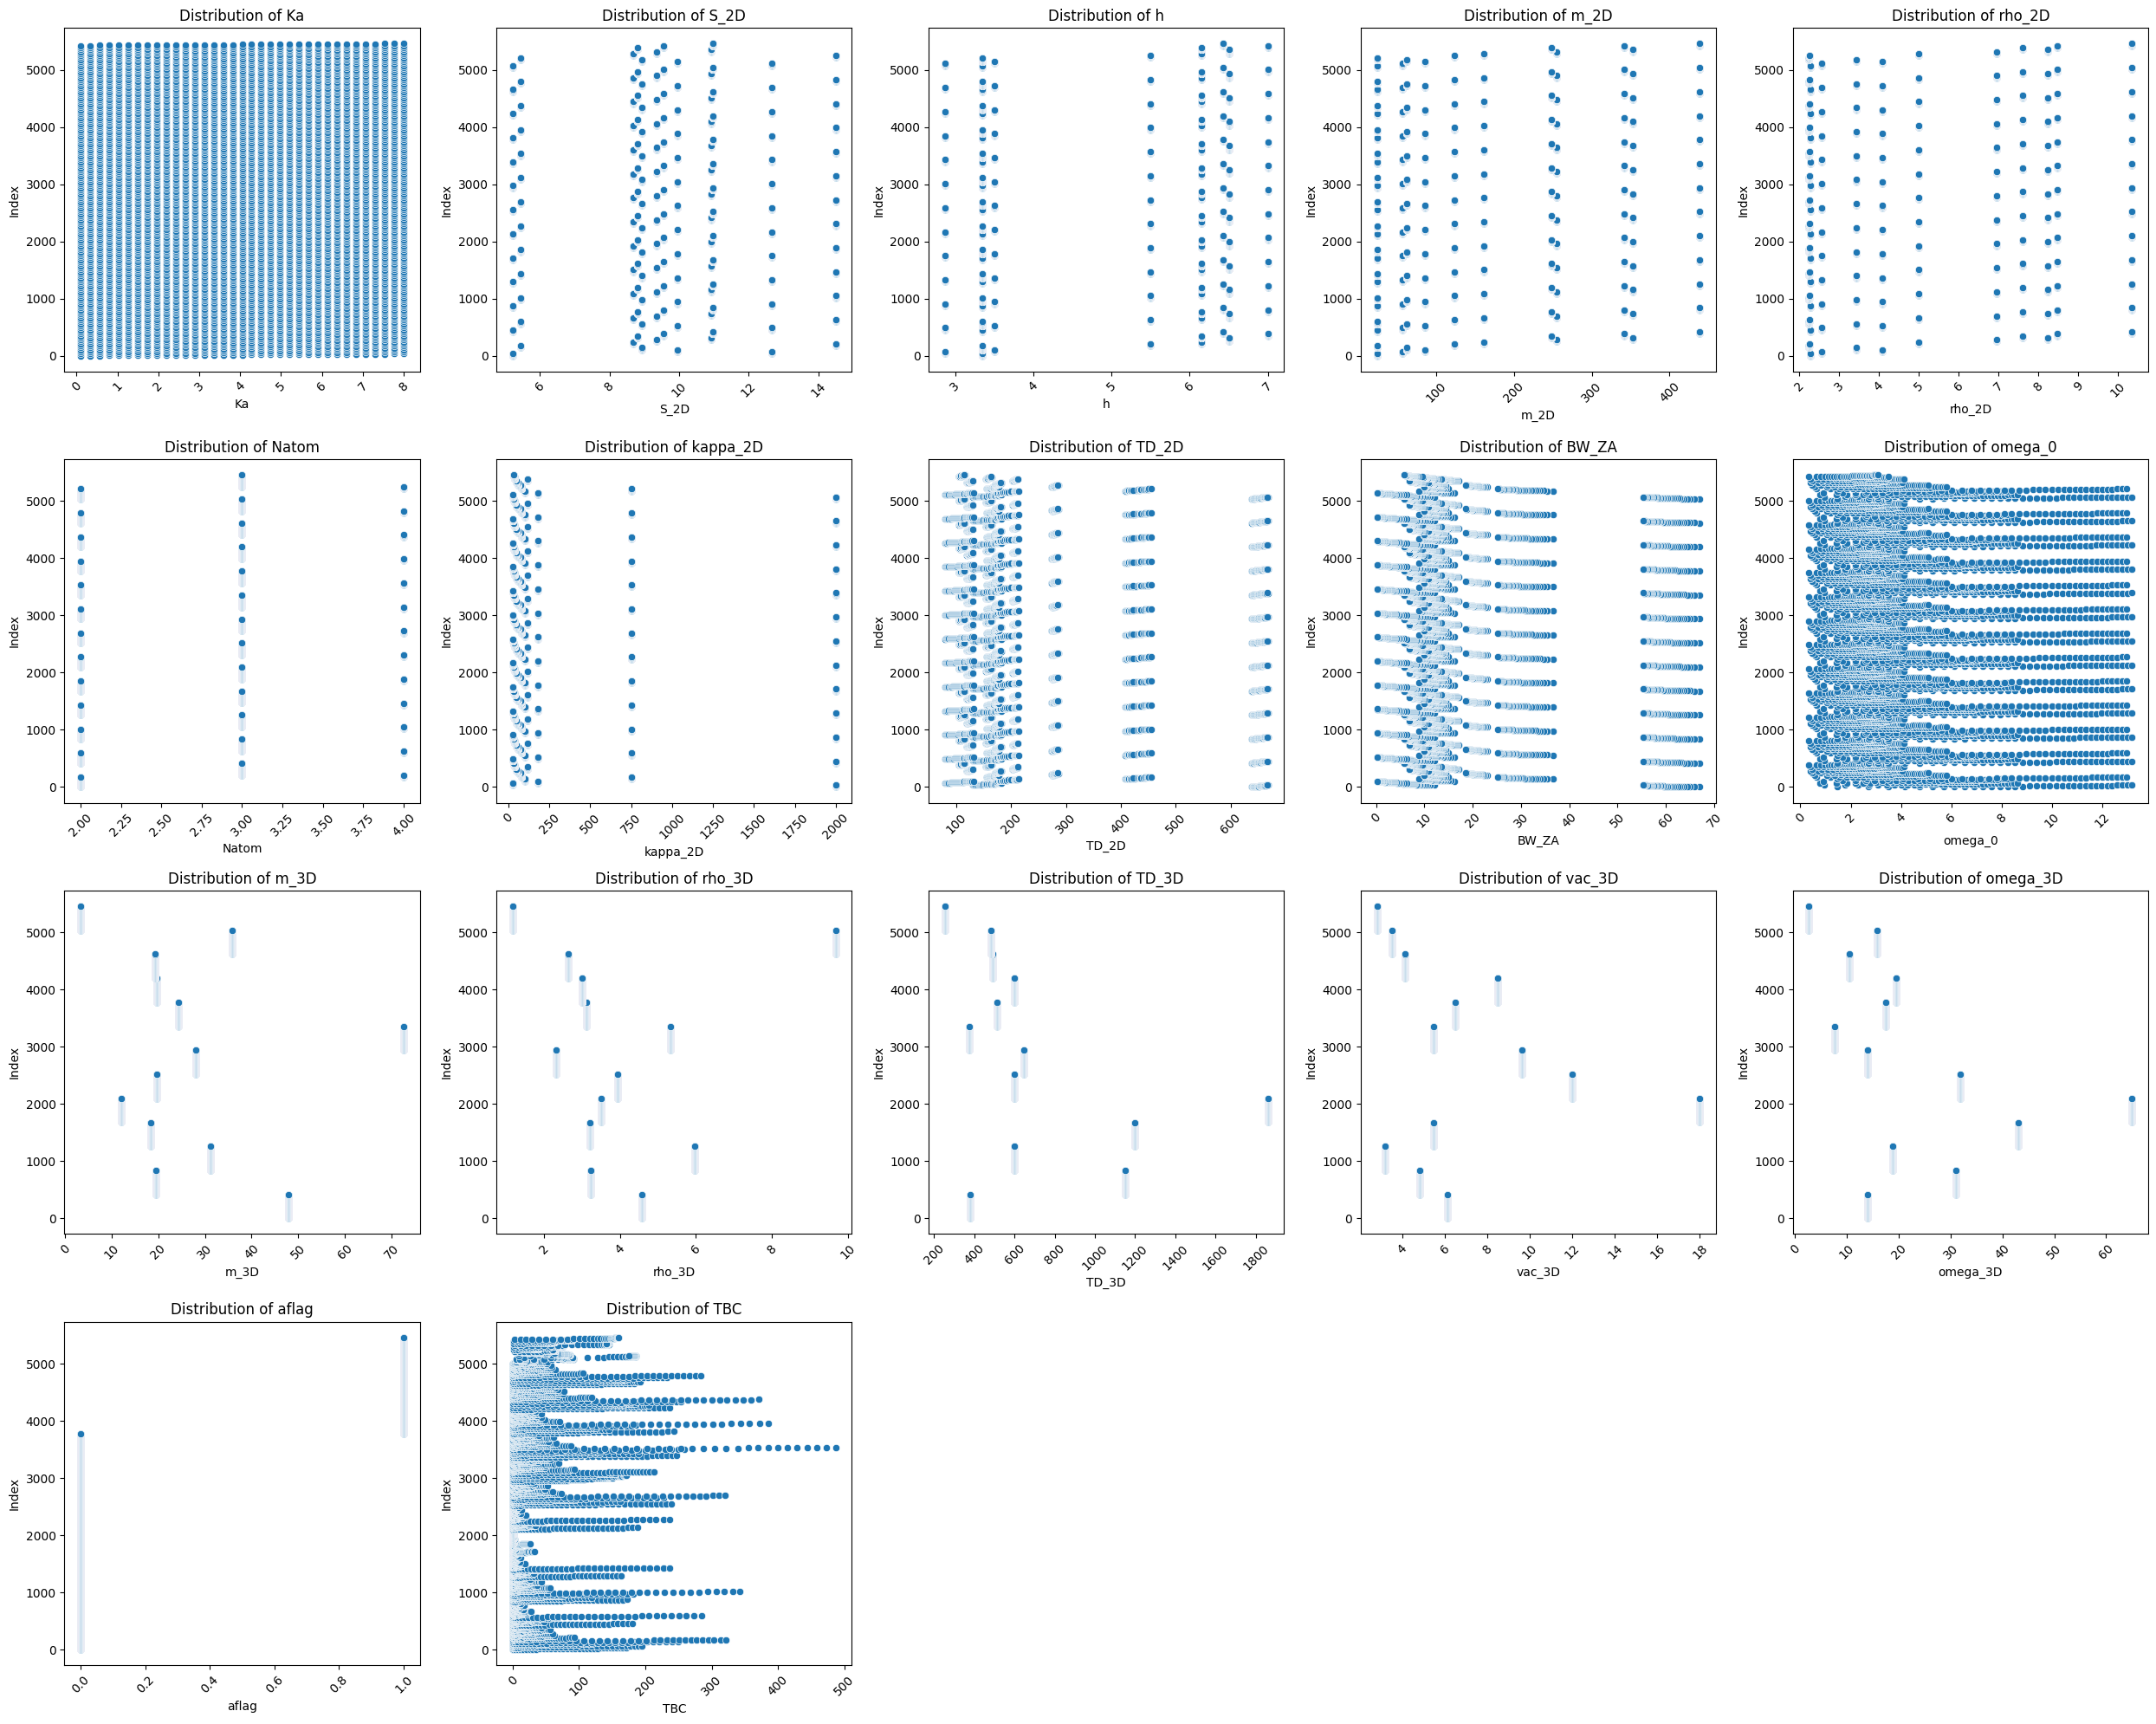

In [14]:
scatter_plot_vars(df=df, vars_to_plot=cols, num_cols=5)

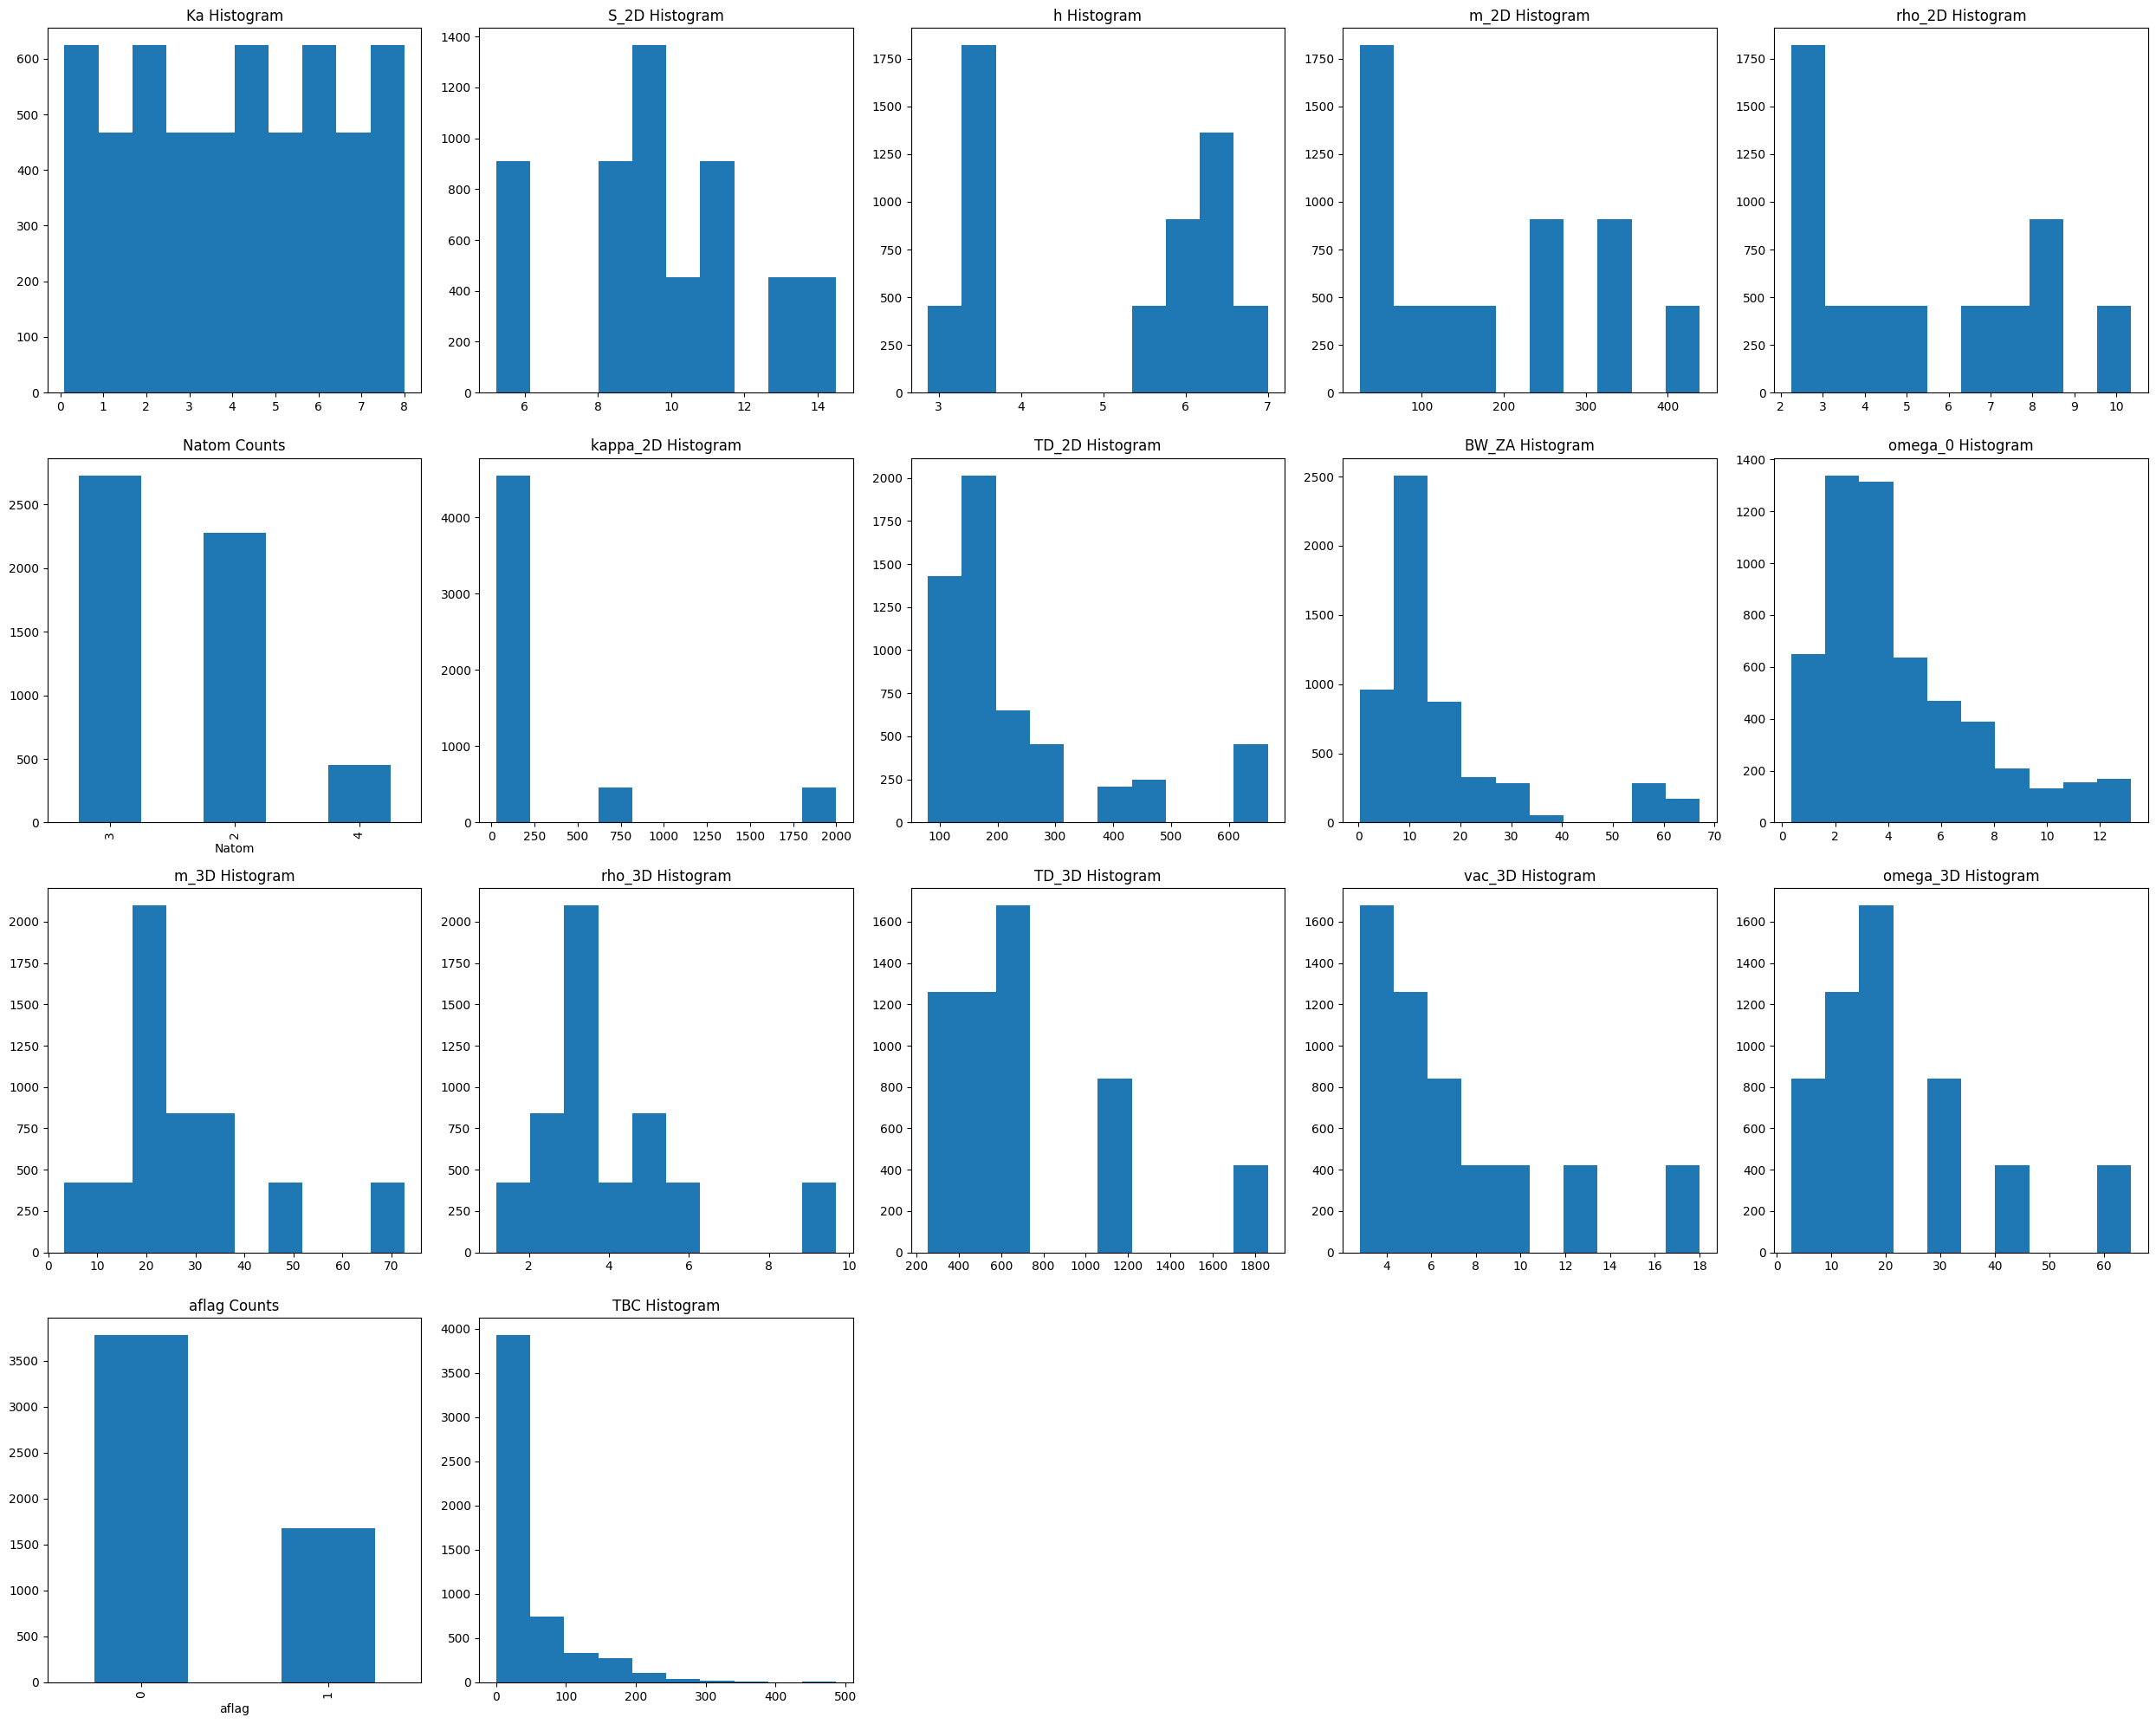

In [15]:
plot_variables(df=df, vars_to_plot=cols, cts_vars=numerical_cols, num_cols=5, hist_num_bins=10)

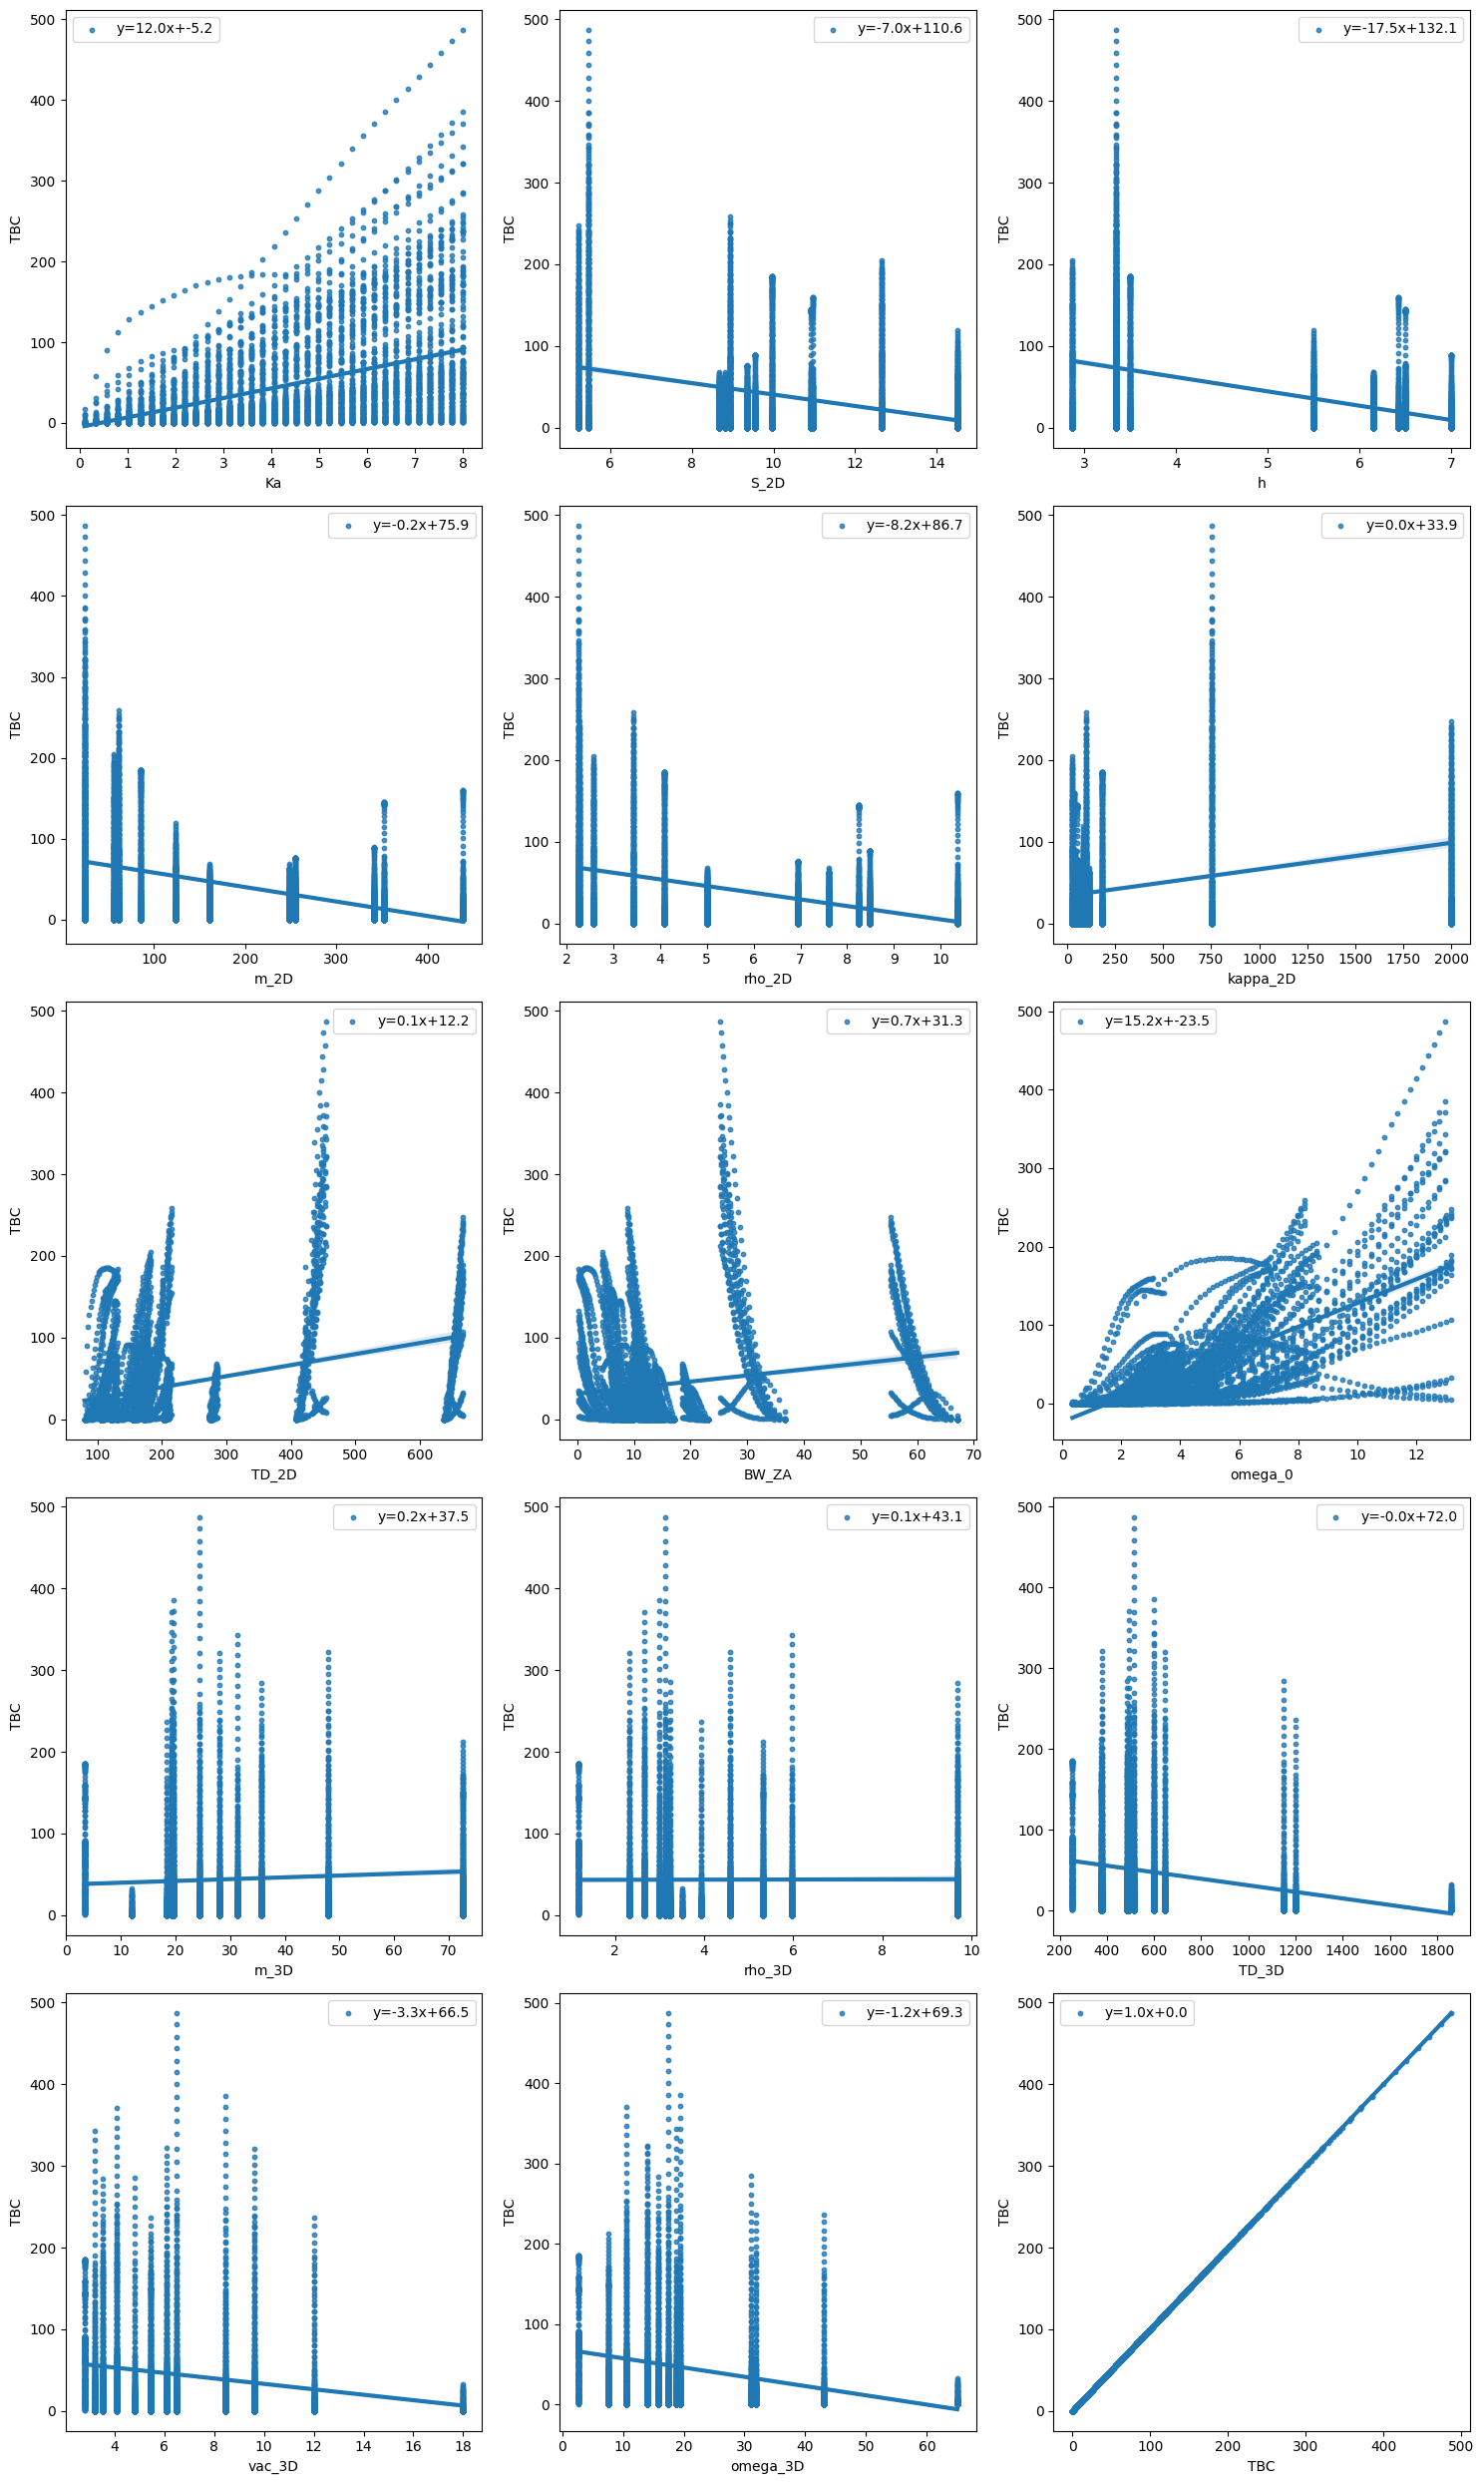

In [16]:
plot_regs(df=df, cts_vars=numerical_cols , response="TBC", num_cols=3, dot_size=10, line_width=3)

#### Main Pipeline For Preprocessing

In [17]:
scaler = StandardScaler()
numerical_features = numerical_cols
numerical_features.pop()
preprocessor = ColumnTransformer(
    transformers=[('numeric', scaler, numerical_features),],
    remainder='passthrough'
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data = pipeline.fit_transform(df)

In [18]:
dataframe = pd.DataFrame(data, columns=cols)
dataframe.head()

,Ka,S_2D,h,m_2D,rho_2D,Natom,kappa_2D,TD_2D,BW_ZA,omega_0,m_3D,rho_3D,TD_3D,vac_3D,omega_3D,aflag,TBC
0,-1.683250,-1.74033,-1.108508,-1.151988,-1.085458,3.111439,2.656597,3.430827,-1.021610,1.233277,0.296614,-0.759886,-0.201198,-0.521097,2.0,0.0,0.150391
1,-1.584267,-1.74033,-1.108508,-1.151988,-1.085458,3.111439,2.663120,3.346405,-0.600108,1.233277,0.296614,-0.759886,-0.201198,-0.521097,2.0,0.0,1.588867
2,-1.485127,-1.74033,-1.108508,-1.151988,-1.085458,3.111439,2.672904,3.291531,-0.317299,1.233277,0.296614,-0.759886,-0.201198,-0.521097,2.0,0.0,4.257812
3,-1.386299,-1.74033,-1.108508,-1.151988,-1.085458,3.111439,2.672904,3.249320,-0.088745,1.233277,0.296614,-0.759886,-0.201198,-0.521097,2.0,0.0,7.757812
4,-1.287264,-1.74033,-1.108508,-1.151988,-1.085458,3.111439,2.679427,3.209219,0.109289,1.233277,0.296614,-0.759886,-0.201198,-0.521097,2.0,0.0,11.796875


## ML Models

### Setup

In [19]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

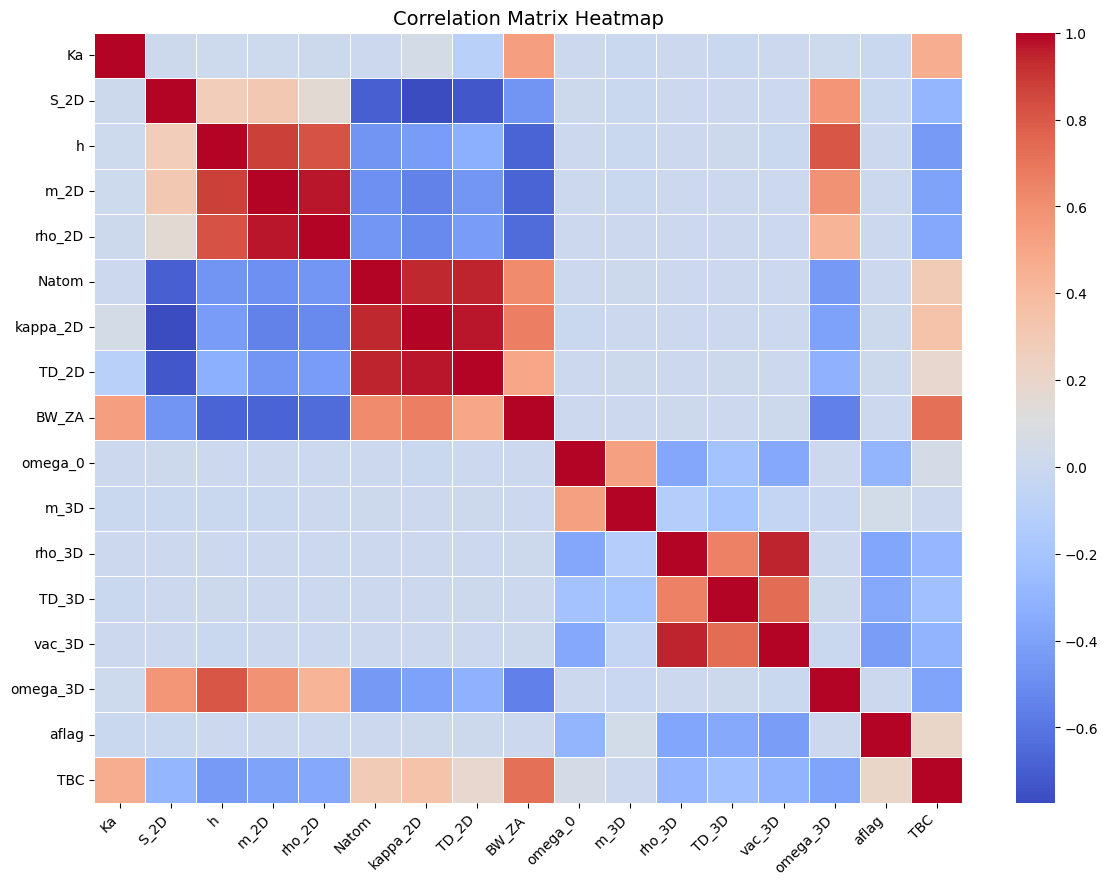

In [20]:
corr_matrix = train_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8},
    )
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [21]:
X, y= train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [22]:
r_squared_threshold = 0.95
r_squared = corr_matrix ** 2
mask = np.triu(np.ones(r_squared.shape), k=1).astype(bool) # mask the upper triangle (including diagonal) to avoid redundancy
r_squared_triu = r_squared.where(mask)
drop_cols = [col for col in r_squared_triu.columns if any(r_squared_triu[col] > r_squared_threshold)]
X = X.drop(drop_cols, axis=1)
print(f"Columns dropped due to high correlation: {drop_cols}")

Columns dropped due to high correlation: []


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, y_test= test_df.iloc[:, :-1].drop(drop_cols, axis=1), test_df.iloc[:, -1]

In [24]:
def eval_reg_model(X_data, X_test, y_data, y_test, model):
    model.fit(X_data, y_data)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    model_name = type(model).__name__
    print("model: {},  rmse = {:.2f}, mae = {:.2f}, r2 = {:.2f}".format(model_name, rmse, mae, r2))

### Linear, Decision Tree, Support Vector, and Random Forest

In [25]:
eval_reg_model(X_train, X_valid, y_train, y_valid, LinearRegression())
eval_reg_model(X_train, X_valid, y_train, y_valid, DecisionTreeRegressor())
eval_reg_model(X_train, X_valid, y_train, y_valid, SVR(kernel="rbf"))
eval_reg_model(X_train, X_valid, y_train, y_valid, RandomForestRegressor())

model: LinearRegression,  rmse = 34.77, mae = 22.73, r2 = 0.65
model: DecisionTreeRegressor,  rmse = 7.51, mae = 3.72, r2 = 0.98
model: SVR,  rmse = 33.81, mae = 16.67, r2 = 0.67
model: RandomForestRegressor,  rmse = 5.18, mae = 2.61, r2 = 0.99


### Random Forest with GridSearchCV

In [26]:
%%time
search_space = {
    "n_estimators": [100, 200, 300],
    "max_features": [10, 15, 20, 25],
    "max_depth": [4, 5, 6, 7]
    }
forest_reg = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=search_space,
                           cv=5, scoring="r2", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
eval_reg_model(X_train, X_valid, y_train, y_valid, grid_search.best_estimator_)

{'max_depth': 7, 'max_features': 15, 'n_estimators': 300}
0.9665195305958543
model: RandomForestRegressor,  rmse = 9.71, mae = 5.67, r2 = 0.97
CPU times: user 5min 57s, sys: 843 ms, total: 5min 57s
Wall time: 6min 15s


Cross-validation Average R2: 0.966200809359661


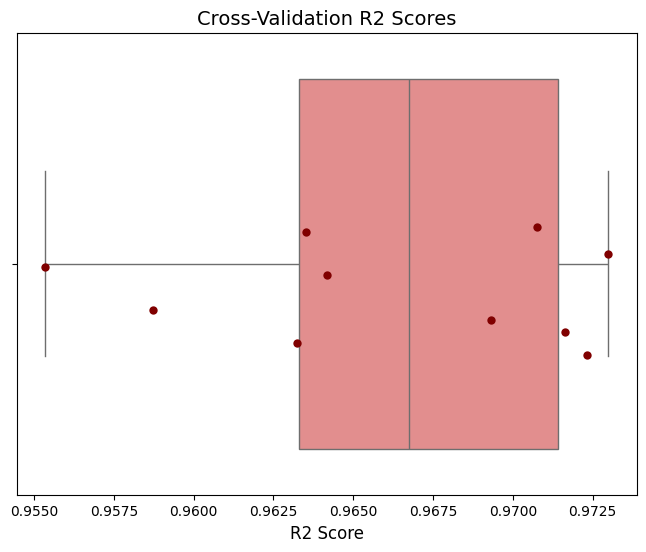

In [27]:
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=10, scoring='r2')

print("Cross-validation Average R2:", scores.mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x=scores, color='lightcoral')
sns.stripplot(x=scores, color='maroon', size=6, jitter=0.2)
plt.title('Cross-Validation R2 Scores', fontsize=14)
plt.xlabel('R2 Score', fontsize=12)
plt.show()

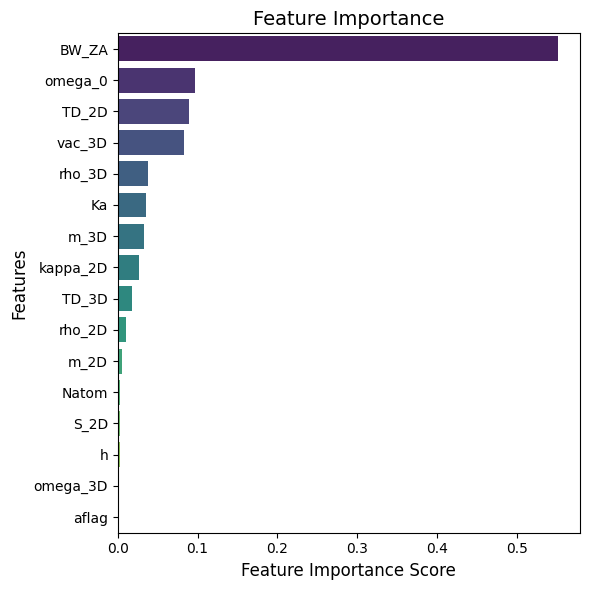

In [28]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_imp = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette="viridis")
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [29]:
explainer = shap.Explainer(grid_search.best_estimator_)
shap_values = explainer(X_test)

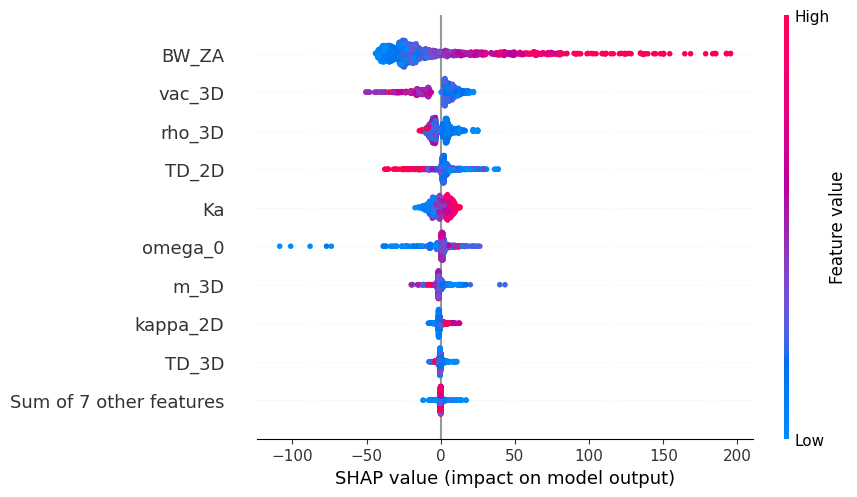

In [30]:
shap.plots.beeswarm(shap_values)

In [31]:
y_pred = grid_search.predict(X_test)

metrics = {
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": mean_squared_error(y_test, y_pred, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
    }

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

MSE: 116.8273
RMSE: 10.8087
MAE: 6.1306
R²: 0.9675


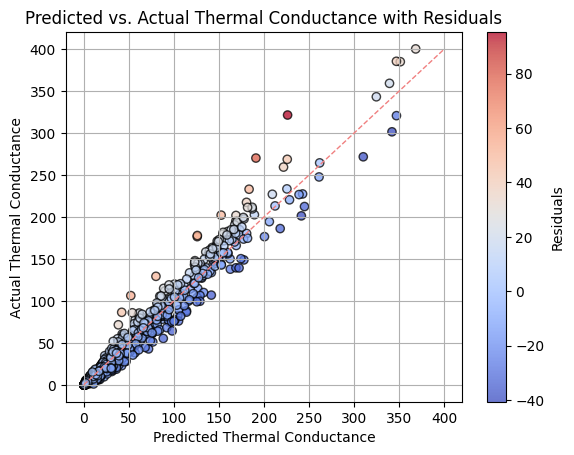

In [32]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Thermal Conductance")
plt.ylabel("Actual Thermal Conductance")
plt.title("Predicted vs. Actual Thermal Conductance with Residuals")
plt.grid(True)
plt.show()

### Bagging, Random Forest, Extra Trees, AdaBoost, Gradient Boosting, and Hist Gradient Boosting

In [33]:
model_list = [
    (BaggingRegressor(estimator= Ridge(), n_estimators=20, random_state=42), "BaggingRegressor"),
    (RandomForestRegressor(random_state=42), "RandomForestRegressor"),
    (ExtraTreesRegressor(random_state=42), "ExtraTreesRegressor"),
    (AdaBoostRegressor(random_state=42), "AdaBoostRegressor"),
    (GradientBoostingRegressor(random_state=42), "GradientBoostingRegressor"),
    (HistGradientBoostingRegressor(random_state=42), "HistGradientBoostingRegressor")
    ]

In [34]:
def fit_model(regressor):

    if hasattr(regressor, 'early_stopping_rounds'):
        regressor.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=10,
            eval_metric='rmse',
            verbose=False
        )
    else:
        regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2


results = []

for reg, name in model_list:
    mse, mae, r2 = fit_model(reg)
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
        })

df = pd.DataFrame(results)
df

,Model,MSE,MAE,R²
0,BaggingRegressor,1152.164429,21.811872,0.679012
1,RandomForestRegressor,28.756450,2.620034,0.991989
2,ExtraTreesRegressor,8.848365,1.415289,0.997535
3,AdaBoostRegressor,974.818902,27.938076,0.728419
4,GradientBoostingRegressor,137.530906,7.107305,0.961684
5,HistGradientBoostingRegressor,22.121848,2.683753,0.993837


Stacking Regressor

In [ ]:
%%time
estimators = [
    ('ridge', Ridge()),
    ('linear', LinearRegression()),
    ('knr', KNeighborsRegressor())
    ]

final_estimator = GradientBoostingRegressor()
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'knr__n_neighbors': [3, 5, 7],
    'final_estimator__n_estimators': [40, 50, 60],
    'final_estimator__learning_rate': [0.01, 0.1, 0.2]
    }


grid_search = GridSearchCV(estimator=stacking_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R²:", r2)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
MSE: 32.9051352625685
R²: 0.9908327639510774
Best Parameters: {'final_estimator__learning_rate': 0.1, 'final_estimator__n_estimators': 50, 'knr__n_neighbors': 3, 'ridge__alpha': 10.0}
CPU times: user 5min 27s, sys: 60 s, total: 6min 27s
Wall time: 4min 50s


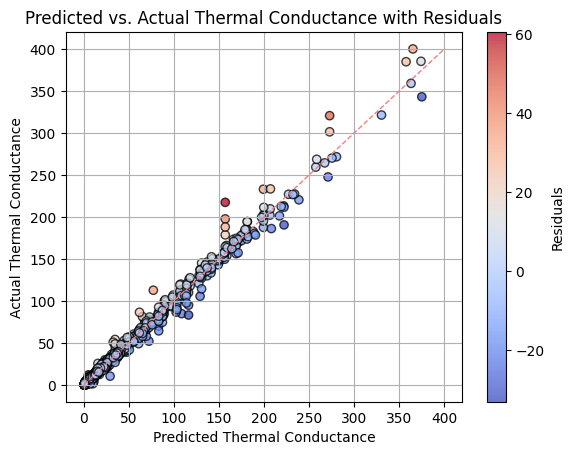

In [37]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Thermal Conductance")
plt.ylabel("Actual Thermal Conductance")
plt.title("Predicted vs. Actual Thermal Conductance with Residuals")
plt.grid(True)
plt.show()

### XGBoost

In [38]:
%%time
param_grid = {
              "max_depth": [6, 8, 10],
              "reg_alpha": [0, 0.2],
              "reg_lambda": [1.0, 3.0, 5.0],
              "colsample_bytree": [0.6, 0.65],
              "colsample_bylevel": [0.65, 0.7],
              "colsample_bynode": [0.75, 0.8, 0.85],
              }



grid_search = GridSearchCV(estimator = xgb.XGBRegressor(objective="reg:squarederror",
                                                         seed=42,
                                                         subsample=0.7,
                                                         early_stopping_rounds=20,
                                                        ),
                           param_grid=param_grid,
                           scoring="neg_root_mean_squared_error",
                           verbose=0,
                           n_jobs=4,
                           cv=2)

grid_search.fit(X_train,
                y_train,
                verbose=False,
                eval_set=[(X_test, y_test)]
                )

CPU times: user 4.46 s, sys: 569 ms, total: 5.03 s
Wall time: 2min 43s


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=20,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bylevel': [0.65, 0.7],
                         'colsample_bynode': [0.75, 0.8, 0.85],
                         'colsample_bytree': [0.6, 0.65],
                         'max_depth': [6, 8, 10], 'reg_alpha': [0, 0.2],
                         'reg_lambda': [1.0, 3.0, 5.0]},
             scoring='neg_root_mean_squared_error')

In [39]:
print(grid_search.best_params_)

{'colsample_bylevel': 0.7, 'colsample_bynode': 0.75, 'colsample_bytree': 0.65, 'max_depth': 10, 'reg_alpha': 0.2, 'reg_lambda': 5.0}


In [40]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [41]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 14.3015
R-squared (R2 Score): 0.9960


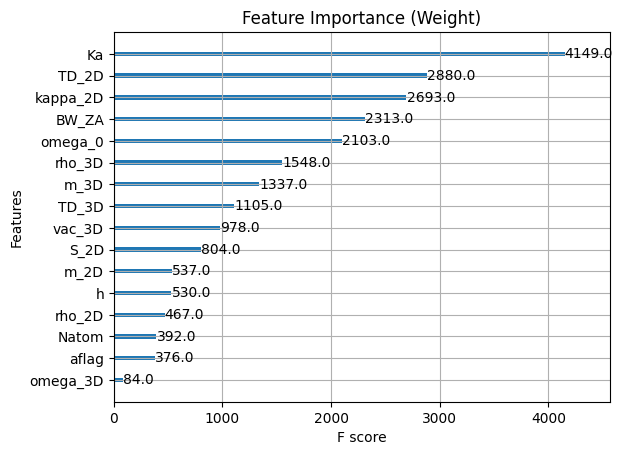

In [42]:
xgb.plot_importance(grid_search.best_estimator_, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

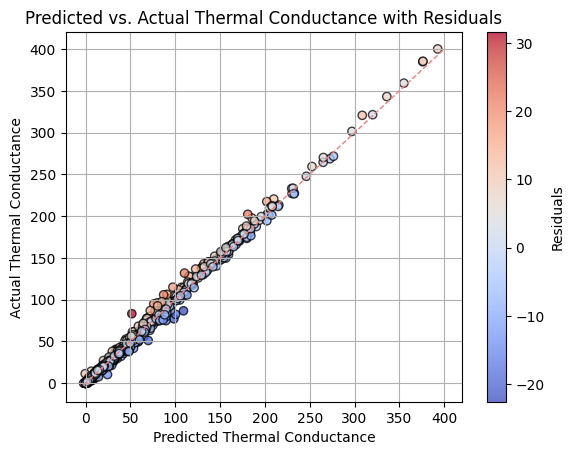

In [43]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Thermal Conductance")
plt.ylabel("Actual Thermal Conductance")
plt.title("Predicted vs. Actual Thermal Conductance with Residuals")
plt.grid(True)
plt.show()

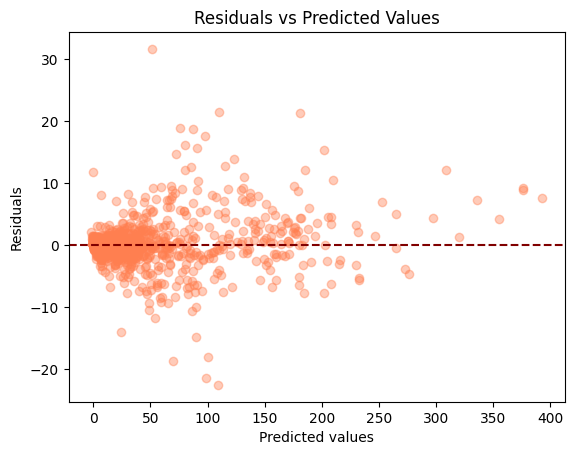

In [44]:
plt.figure()
plt.scatter(y_pred, residuals, color="coral", alpha=0.4)
plt.axhline(y=0, color='maroon', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

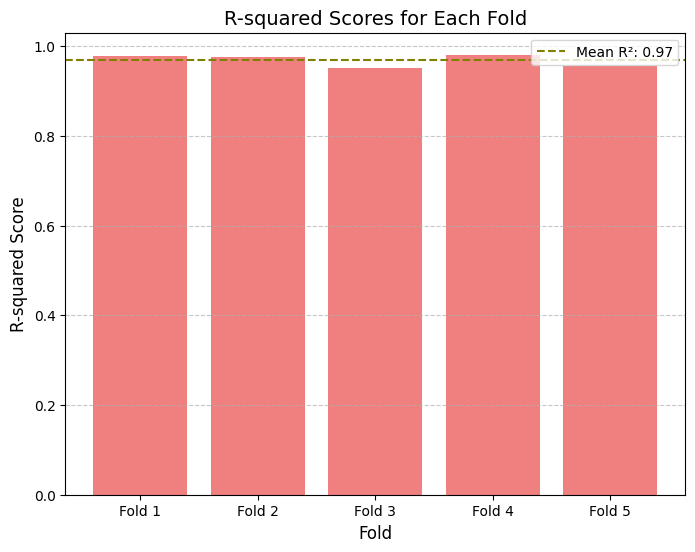

Mean R2 score: 0.9691043376922608


In [45]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

for xt_index, xv_index in kfolds.split(X_test):
    Xt_fold, Xv_fold = X_test.iloc[xt_index], X_test.iloc[xv_index]
    yt_fold, yv_fold = y_test.iloc[xt_index], y_test.iloc[xv_index]

    best_estimator = grid_search.best_estimator_
    best_estimator.fit(Xt_fold, yt_fold,
                       eval_set=[(Xv_fold, yv_fold)],
                       verbose=False)

    pred = best_estimator.predict(Xv_fold)
    r2 = r2_score(yv_fold, pred)
    r2_scores.append(r2)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(r2_scores)), r2_scores, color='lightcoral')
plt.axhline(y=np.mean(r2_scores), color='olive', linestyle='--', label=f'Mean R²: {np.mean(r2_scores):.2f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.title('R-squared Scores for Each Fold', fontsize=14)
plt.xticks(np.arange(len(r2_scores)), [f'Fold {i+1}' for i in range(len(r2_scores))])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
print(f"Mean R2 score: {np.mean(r2_scores)}")

### LightGBM

In [46]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [47]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }

param_dist = {
    'num_leaves': [7, 13, 17, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 500, 700]
    }

In [48]:
%%time
lgb_estimator = lgb.LGBMRegressor(**params)

random_search = RandomizedSearchCV(estimator=lgb_estimator,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
CPU times: user 2.1 s, sys: 198 ms, total: 2.3 s
Wall time: 1min 14s


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                           feature_fraction=0.9, metric='l2',
                                           objective='regression', verbose=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'n_estimators': [200, 500, 700],
                                        'num_leaves': [7, 13, 17, 20]})

In [49]:
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'num_leaves': 13, 'n_estimators': 700, 'learning_rate': 0.2}


In [50]:
y_pred = random_search.best_estimator_.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [51]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 9.3310
R-squared (R2 Score): 0.9974


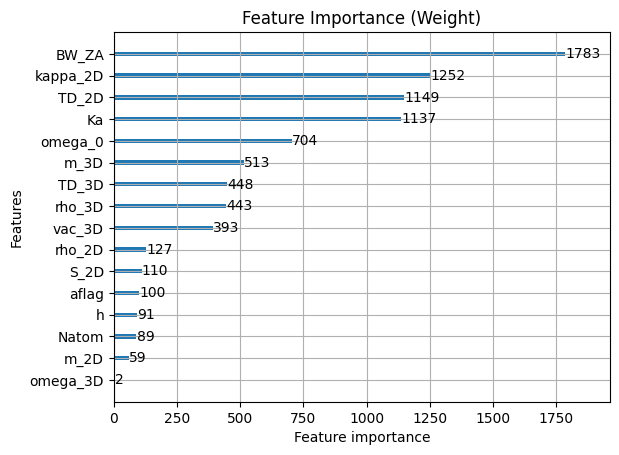

In [52]:
lgb.plot_importance(random_search.best_estimator_)
plt.title('Feature Importance (Weight)')
plt.show()

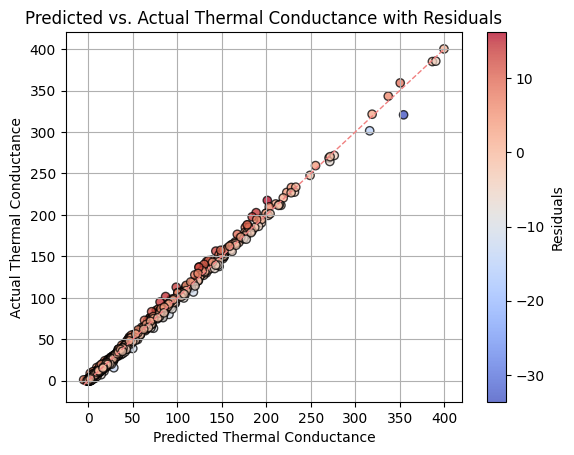

In [53]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Thermal Conductance")
plt.ylabel("Actual Thermal Conductance")
plt.title("Predicted vs. Actual Thermal Conductance with Residuals")
plt.grid(True)
plt.show()

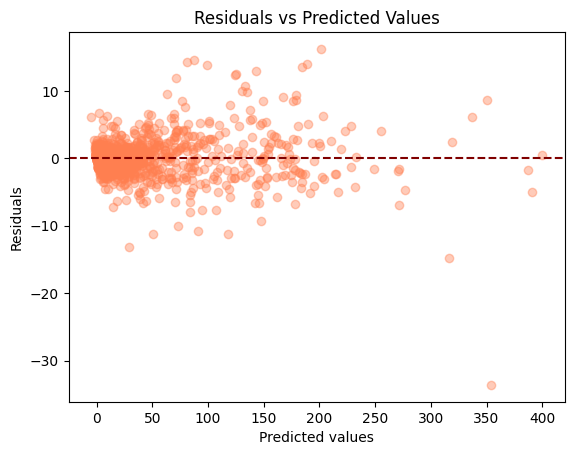

In [54]:
plt.figure()
plt.scatter(y_pred, residuals, color="coral", alpha=0.4)
plt.axhline(y=0, color='maroon', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

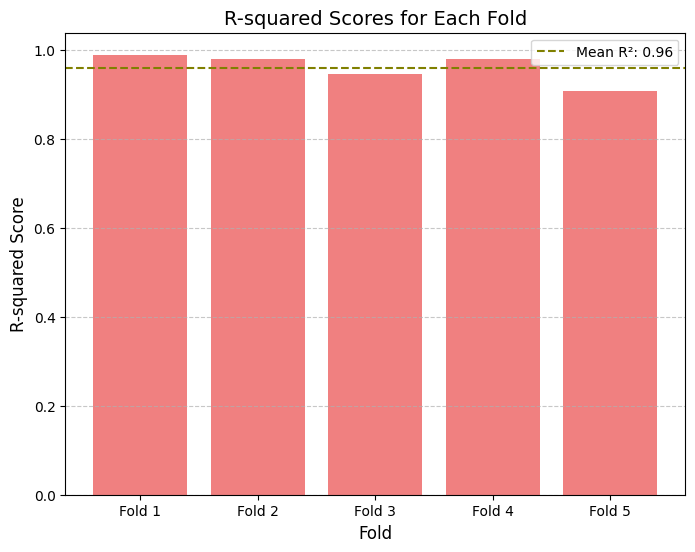

Mean R2 score: 0.9611654340744554


In [55]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []

for xt_index, xv_index in kfolds.split(X_test):
    Xt_fold, Xv_fold = X_test.iloc[xt_index], X_test.iloc[xv_index]
    yt_fold, yv_fold = y_test.iloc[xt_index], y_test.iloc[xv_index]

    best_estimator = random_search.best_estimator_
    best_estimator.fit(Xt_fold, yt_fold,
                       eval_set=[(Xv_fold, yv_fold)])

    pred = best_estimator.predict(Xv_fold)
    r2 = r2_score(yv_fold, pred)
    r2_scores.append(r2)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(r2_scores)), r2_scores, color='lightcoral')
plt.axhline(y=np.mean(r2_scores), color='olive', linestyle='--', label=f'Mean R²: {np.mean(r2_scores):.2f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.title('R-squared Scores for Each Fold', fontsize=14)
plt.xticks(np.arange(len(r2_scores)), [f'Fold {i+1}' for i in range(len(r2_scores))])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
print(f"Mean R2 score: {np.mean(r2_scores)}")